In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
column_names = [
    "hotel_name", "city", "country", "price_per_night_text", "price_per_night", 
    "rating", "review_count_text", "review_count", "stars", "location", "amenities"
]

df = pd.read_csv("vietnam_hotels_data.csv", names=column_names, na_values="?")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221 entries, 0 to 220
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   hotel_name            221 non-null    object
 1   city                  221 non-null    object
 2   country               221 non-null    object
 3   price_per_night_text  221 non-null    object
 4   price_per_night       221 non-null    object
 5   rating                214 non-null    object
 6   review_count_text     214 non-null    object
 7   review_count          214 non-null    object
 8   stars                 219 non-null    object
 9   location              221 non-null    object
 10  amenities             221 non-null    object
dtypes: object(11)
memory usage: 19.1+ KB


# DATA CLEANING

In [4]:
df['price_per_night'] = pd.to_numeric(df['price_per_night'], errors='coerce')
df['review_count'] = pd.to_numeric(df['review_count'], errors='coerce')
df['stars'] = pd.to_numeric(df['stars'], errors='coerce')
df['rating_numeric'] = df['rating'].str.extract(r'(\d+\.?\d*)').astype(float)
df['rating_text'] = df['rating'].str.extract(r'(\w+(?:\s+\w+)*)')

def count_amenities(amenities_str):
    if pd.isna(amenities_str) or amenities_str == '[]':
        return 0
    try:
        amenities_list = eval(amenities_str)
        return len(amenities_list)
    except:
        return 0

df['amenities_count'] = df['amenities'].apply(count_amenities)

df['distance_to_center'] = df['location'].str.extract(r'(\d+\.?\d*)\s*km to center')
df['distance_to_center'] = pd.to_numeric(df['distance_to_center'], errors='coerce')
df['is_city_center'] = df['location'].str.contains('City center', case=False, na=False)

city_dummies = pd.get_dummies(df['city'], prefix='city')
df = pd.concat([df, city_dummies], axis=1)

essential_columns = [
    'price_per_night', 'rating_numeric', 'stars', 
    'hotel_name', 'city', 'amenities_count'
]

df_clean = df.dropna(subset=['price_per_night', 'rating_numeric', 'stars']).copy()

remaining_missing = df_clean.isnull().sum()
total_missing = remaining_missing.sum()

if 'distance_to_center' in df_clean.columns:
    distance_median = df_clean['distance_to_center'].median()
    missing_distance = df_clean['distance_to_center'].isnull().sum()
    if missing_distance > 0:
        df_clean['distance_to_center'].fillna(distance_median, inplace=True)

if 'review_count' in df_clean.columns:
    review_median = df_clean['review_count'].median()
    missing_reviews = df_clean['review_count'].isnull().sum()
    if missing_reviews > 0:
        df_clean['review_count'].fillna(review_median, inplace=True)
        

key_columns = ['price_per_night', 'rating_numeric', 'stars', 'amenities_count', 'city']
final_missing = df_clean[key_columns].isnull().sum().sum()

df = df_clean.copy()

# EXPLORATORY DATA ANALYSIS

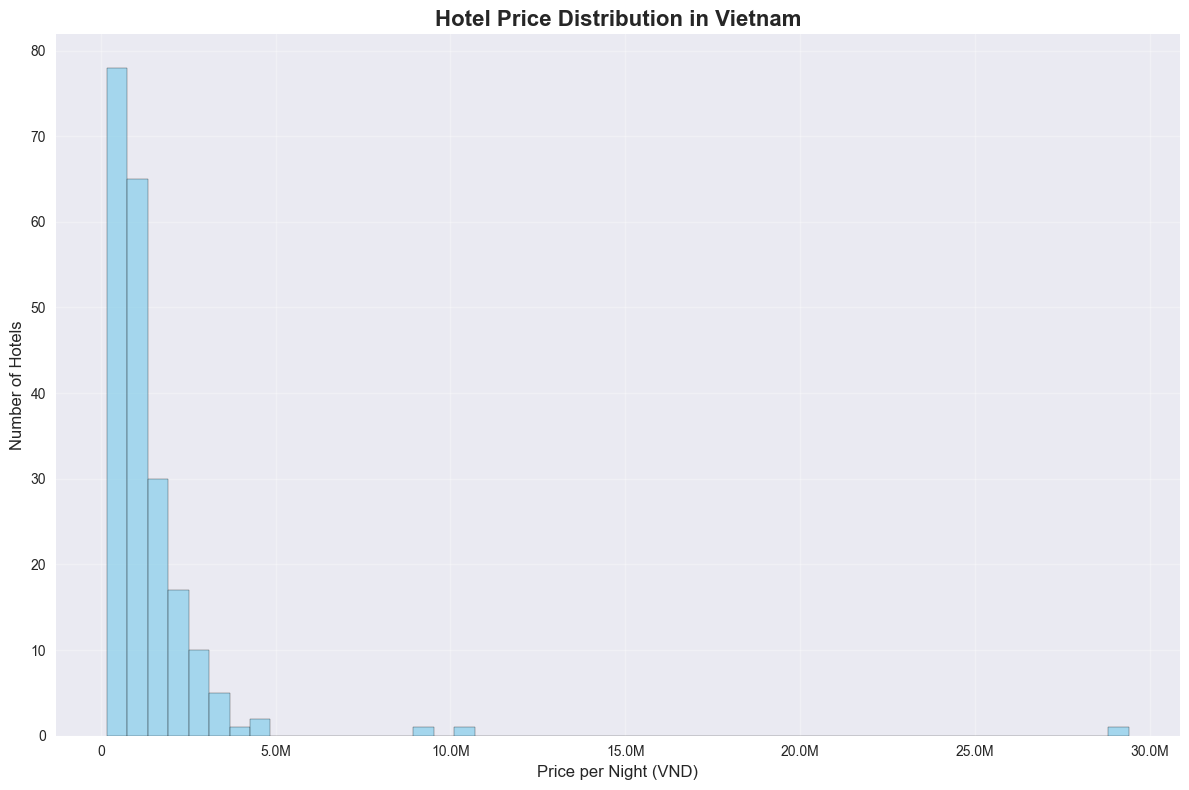

In [5]:
# 1. PRICE DISTRIBUTION
plt.figure(figsize=(12, 8))
plt.hist(df['price_per_night'].dropna(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Hotel Price Distribution in Vietnam', fontsize=16, fontweight='bold')
plt.xlabel('Price per Night (VND)', fontsize=12)
plt.ylabel('Number of Hotels', fontsize=12)
ax = plt.gca()
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M' if x >= 1e6 else f'{x/1e3:.0f}K' if x >= 1e3 else f'{x:.0f}'))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

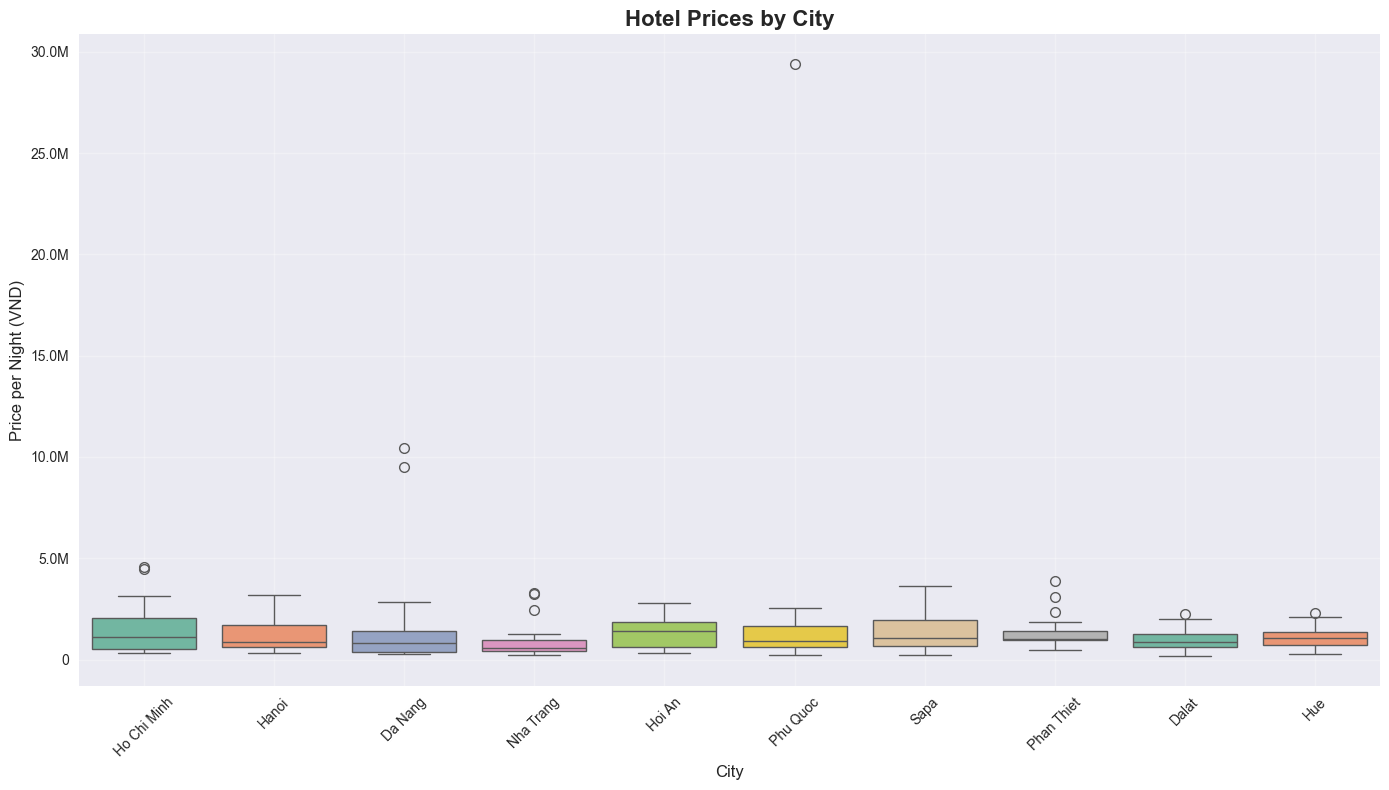

In [6]:
# 2. PRICE BY CITY
plt.figure(figsize=(14, 8))
sns.boxplot(data=df, x='city', y='price_per_night', palette='Set2')
plt.title('Hotel Prices by City', fontsize=16, fontweight='bold')
plt.xlabel('City', fontsize=12)
plt.ylabel('Price per Night (VND)', fontsize=12)
plt.xticks(rotation=45)
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M' if x >= 1e6 else f'{x/1e3:.0f}K' if x >= 1e3 else f'{x:.0f}'))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

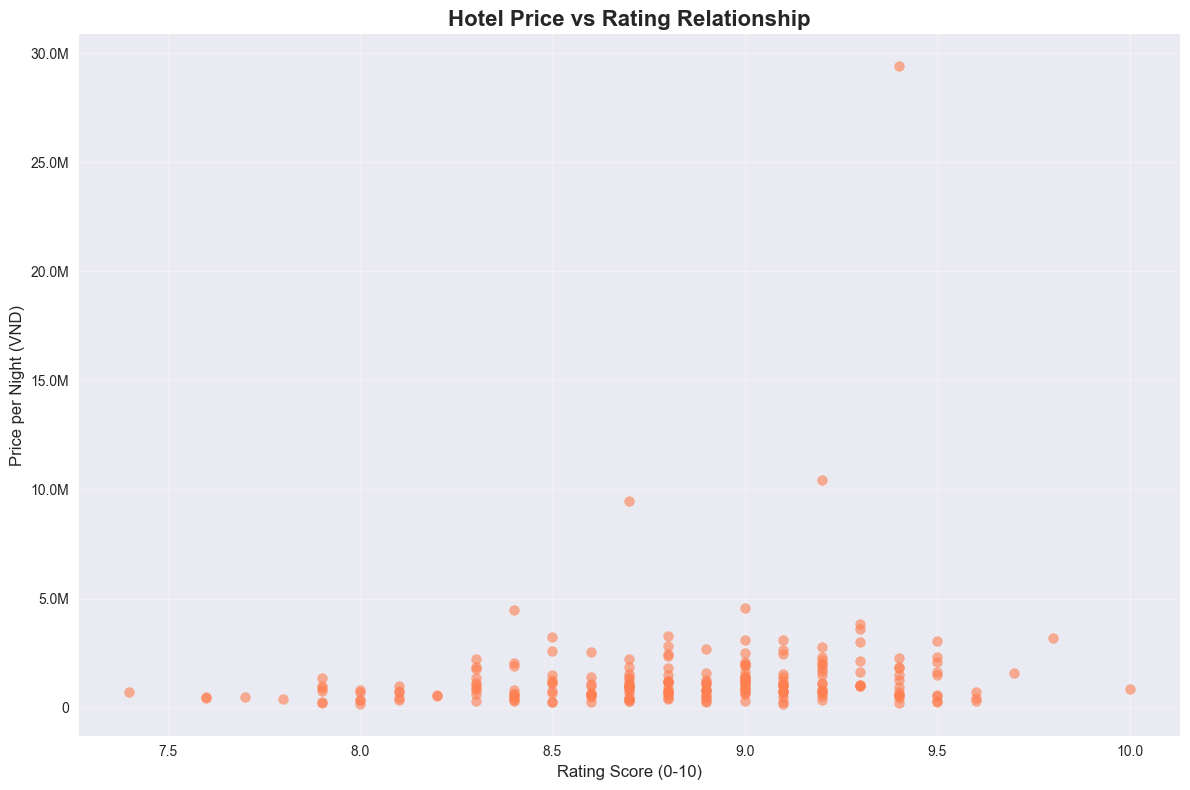

In [7]:
# 3. PRICE VS RATING
plt.figure(figsize=(12, 8))
plt.scatter(df['rating_numeric'], df['price_per_night'], alpha=0.6, color='coral', s=50)
plt.xlabel('Rating Score (0-10)', fontsize=12)
plt.ylabel('Price per Night (VND)', fontsize=12)
plt.title('Hotel Price vs Rating Relationship', fontsize=16, fontweight='bold')
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M' if x >= 1e6 else f'{x/1e3:.0f}K' if x >= 1e3 else f'{x:.0f}'))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

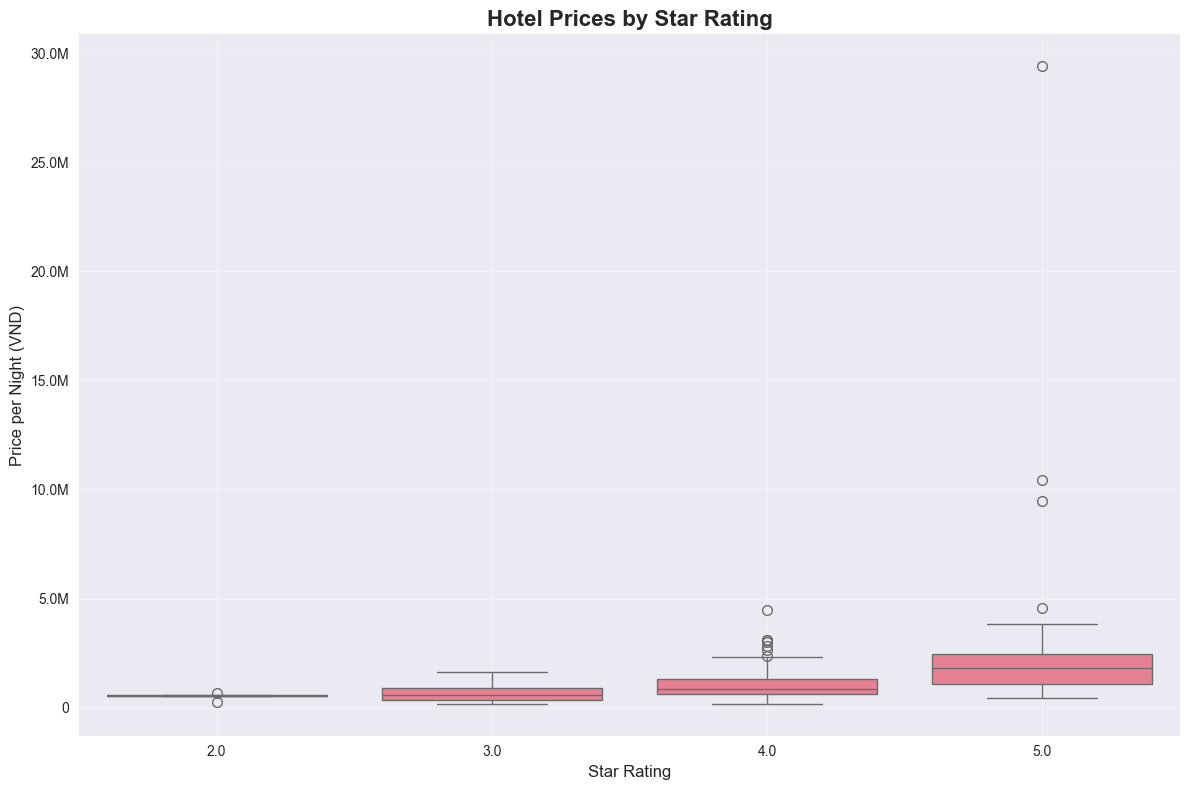

In [8]:
# 4. PRICE BY STAR RATING
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='stars', y='price_per_night', ax=plt.gca())
plt.title('Hotel Prices by Star Rating', fontsize=16, fontweight='bold')
plt.xlabel('Star Rating', fontsize=12)
plt.ylabel('Price per Night (VND)', fontsize=12)
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M' if x >= 1e6 else f'{x/1e3:.0f}K' if x >= 1e3 else f'{x:.0f}'))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

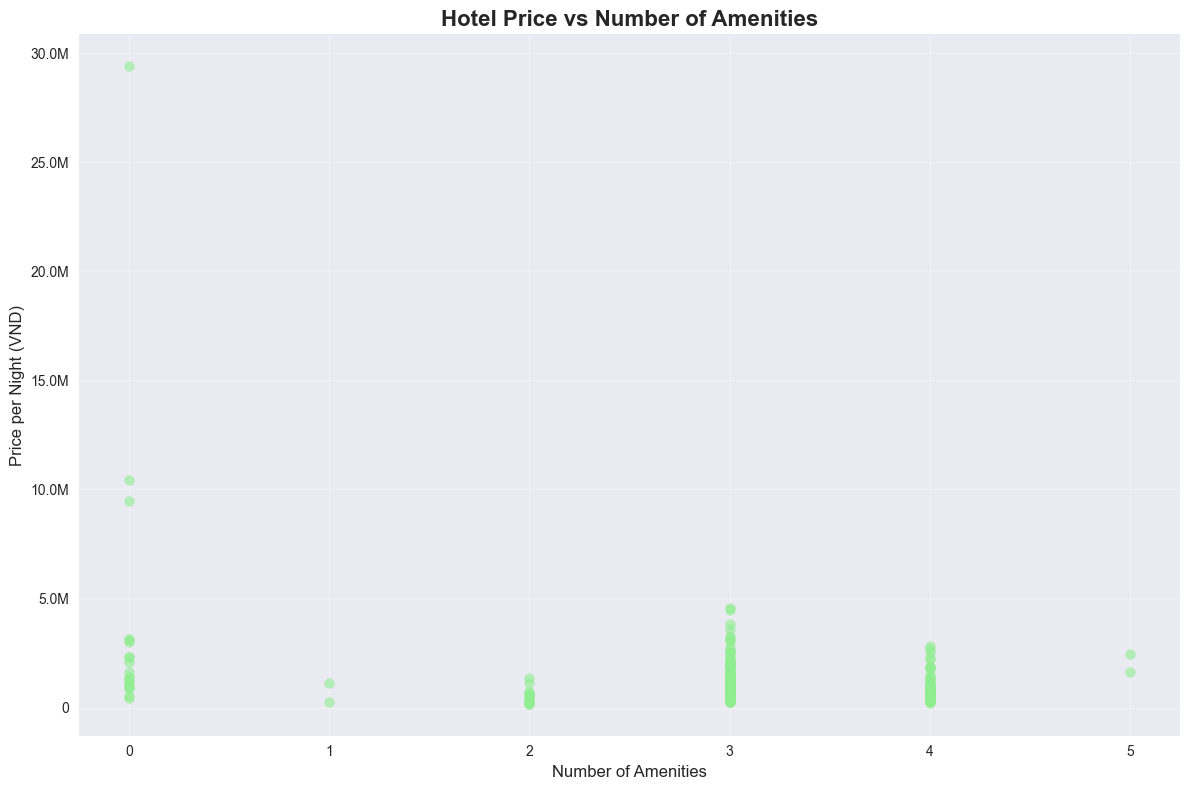

In [9]:
# 5. AMENITIES VS PRICE
plt.figure(figsize=(12, 8))
plt.scatter(df['amenities_count'], df['price_per_night'], alpha=0.6, color='lightgreen', s=50)
plt.xlabel('Number of Amenities', fontsize=12)
plt.ylabel('Price per Night (VND)', fontsize=12)
plt.title('Hotel Price vs Number of Amenities', fontsize=16, fontweight='bold')
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M' if x >= 1e6 else f'{x/1e3:.0f}K' if x >= 1e3 else f'{x:.0f}'))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

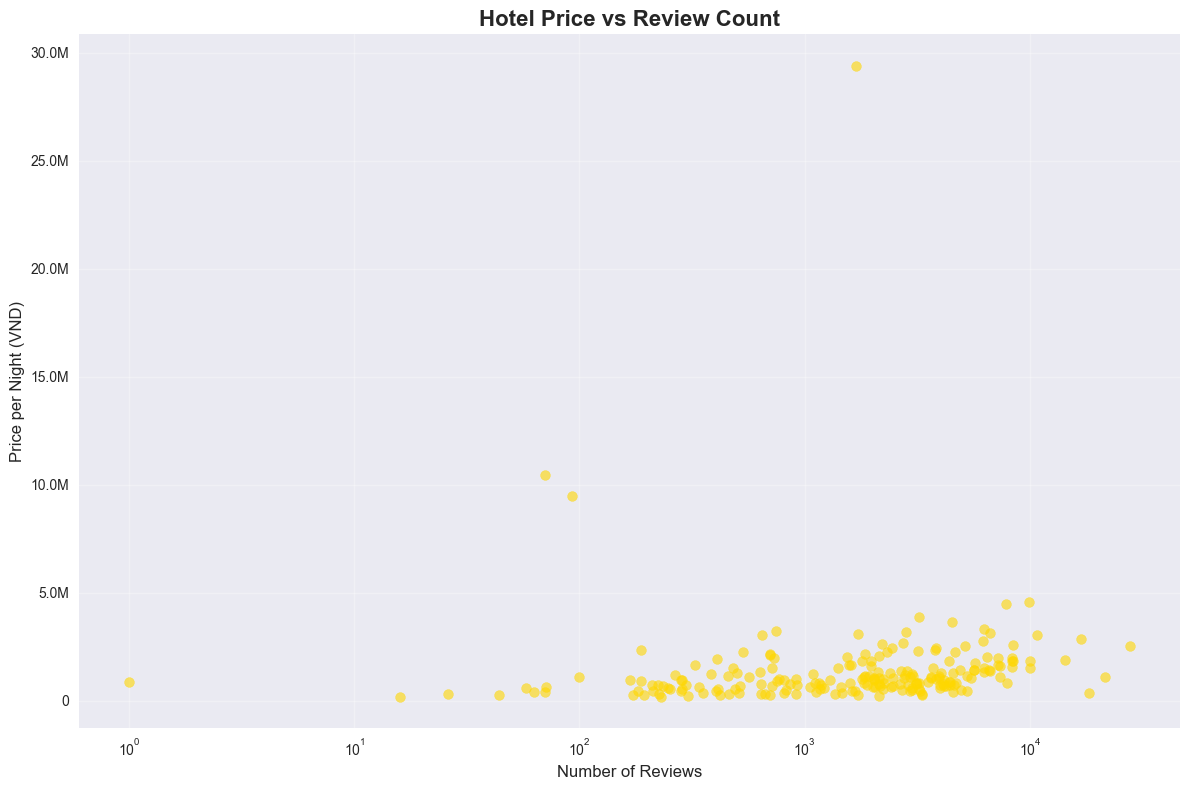

In [10]:
# 6. REVIEWS VS PRICE
plt.figure(figsize=(12, 8))
valid_data = df[['review_count', 'price_per_night']].dropna()
plt.scatter(valid_data['review_count'], valid_data['price_per_night'], alpha=0.6, color='gold', s=50)
plt.xlabel('Number of Reviews', fontsize=12)
plt.ylabel('Price per Night (VND)', fontsize=12)
plt.title('Hotel Price vs Review Count', fontsize=16, fontweight='bold')
plt.xscale('log')
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M' if x >= 1e6 else f'{x/1e3:.0f}K' if x >= 1e3 else f'{x:.0f}'))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

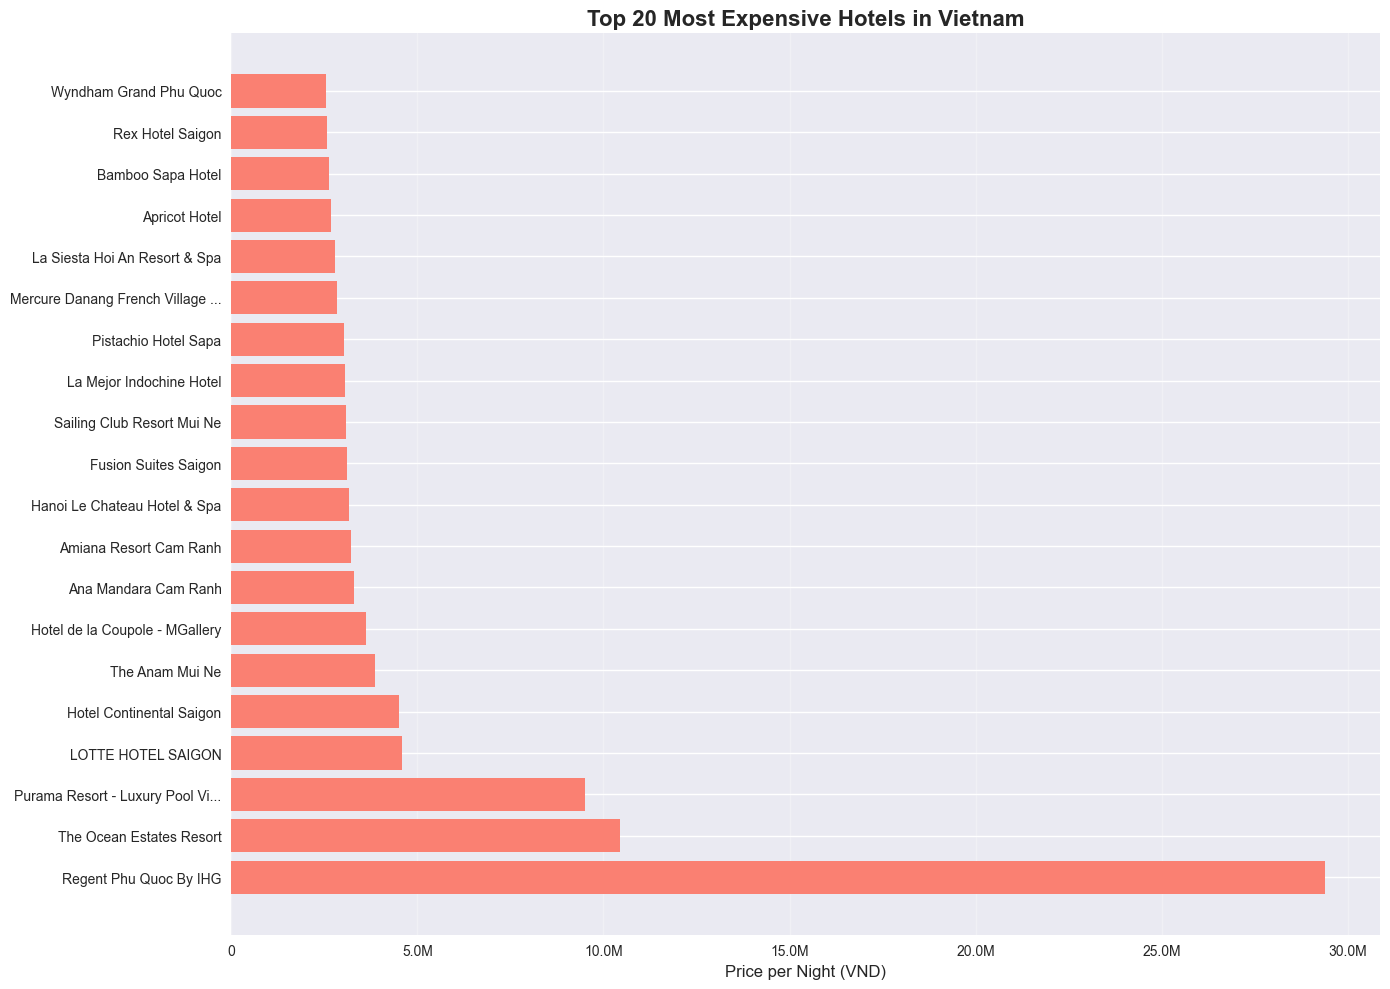

In [11]:
# 7. TOP EXPENSIVE HOTELS
plt.figure(figsize=(14, 10))
top_expensive = df.nlargest(20, 'price_per_night')
plt.barh(range(len(top_expensive)), top_expensive['price_per_night'], color='salmon')
plt.yticks(range(len(top_expensive)), 
           [f"{name[:30]}{'...' if len(name) > 30 else ''}" for name in top_expensive['hotel_name']], 
           fontsize=10)
plt.xlabel('Price per Night (VND)', fontsize=12)
plt.title('Top 20 Most Expensive Hotels in Vietnam', fontsize=16, fontweight='bold')
ax = plt.gca()
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M' if x >= 1e6 else f'{x/1e3:.0f}K' if x >= 1e3 else f'{x:.0f}'))
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

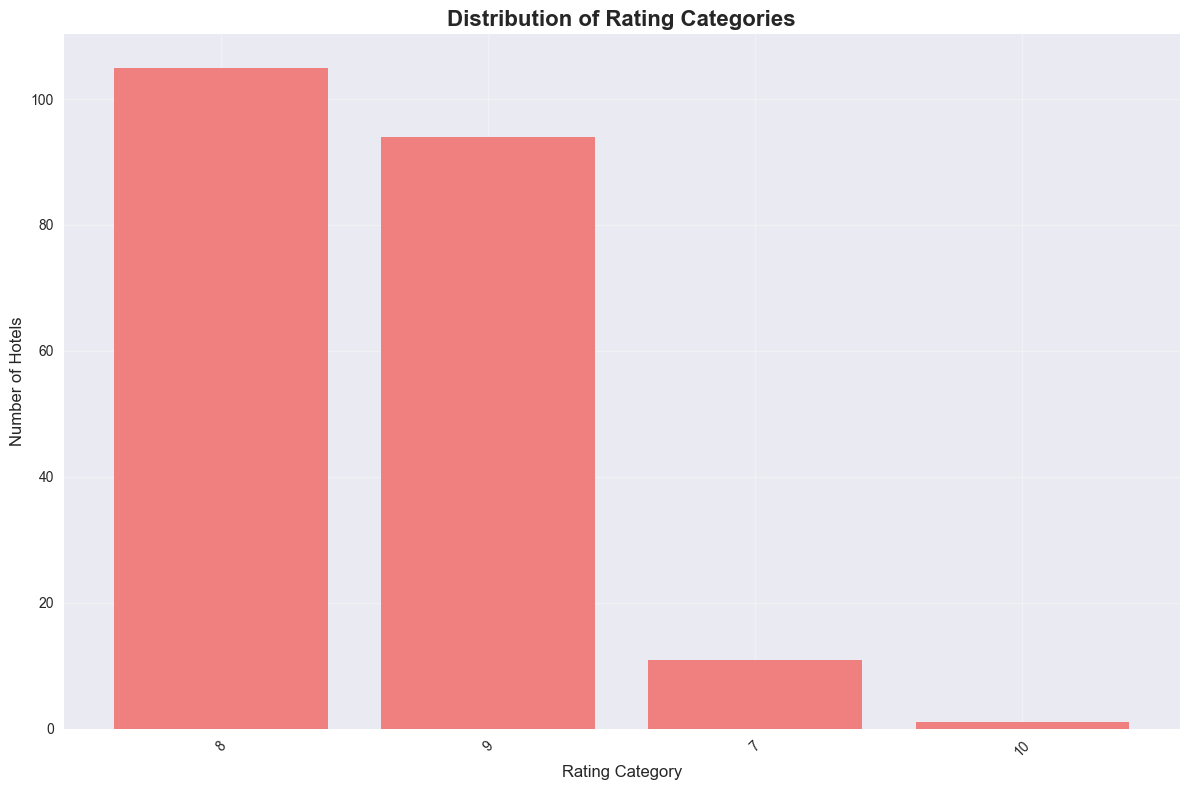

In [12]:
# 8. RATING TEXT DISTRIBUTION
plt.figure(figsize=(12, 8))
rating_counts = df['rating_text'].value_counts()
plt.bar(rating_counts.index, rating_counts.values, color='lightcoral')
plt.title('Distribution of Rating Categories', fontsize=16, fontweight='bold')
plt.xlabel('Rating Category', fontsize=12)
plt.ylabel('Number of Hotels', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

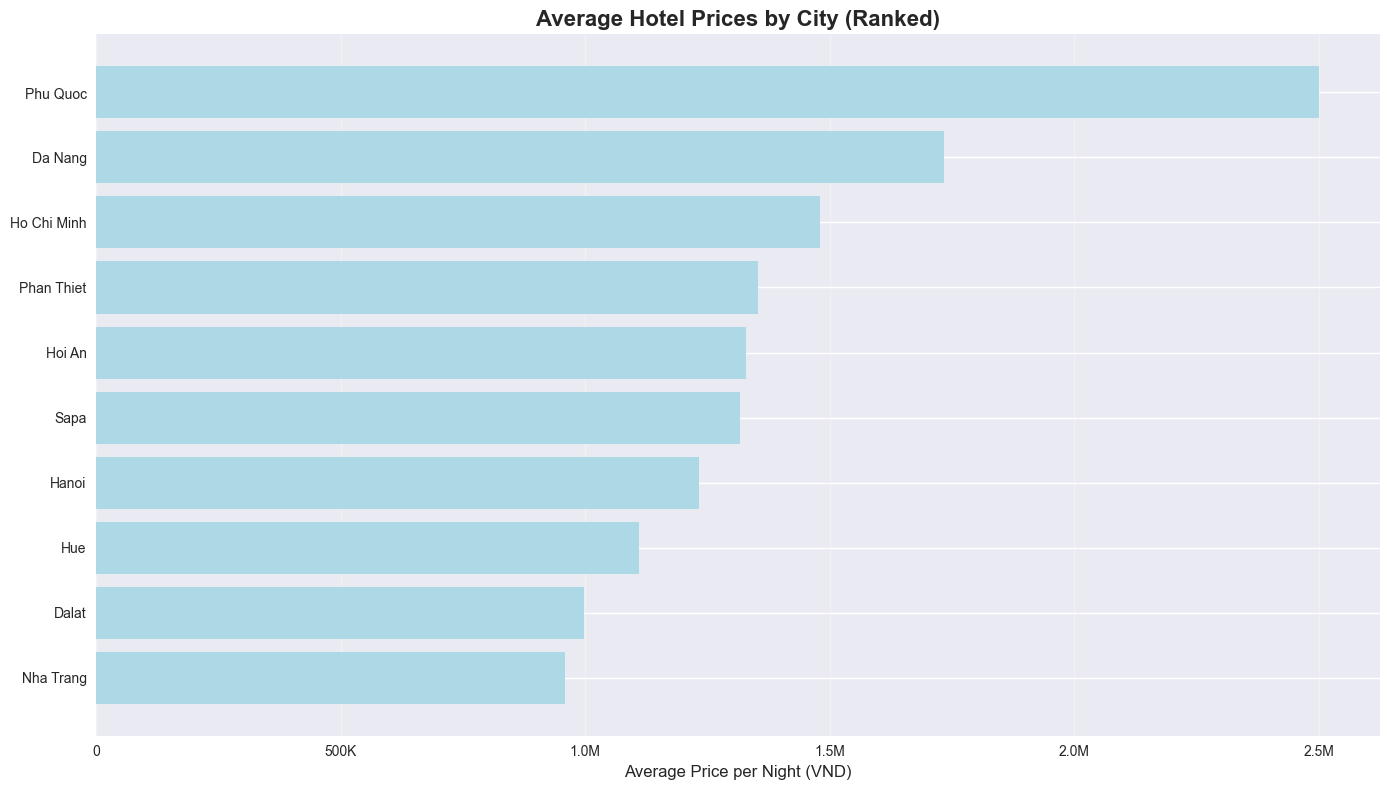

In [13]:
# 9. AVERAGE PRICE BY CITY
plt.figure(figsize=(14, 8))
avg_price_by_city = df.groupby('city')['price_per_night'].mean().sort_values(ascending=True)
plt.barh(range(len(avg_price_by_city)), avg_price_by_city.values, color='lightblue')
plt.yticks(range(len(avg_price_by_city)), avg_price_by_city.index)
plt.xlabel('Average Price per Night (VND)', fontsize=12)
plt.title('Average Hotel Prices by City (Ranked)', fontsize=16, fontweight='bold')
ax = plt.gca()
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M' if x >= 1e6 else f'{x/1e3:.0f}K' if x >= 1e3 else f'{x:.0f}'))
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

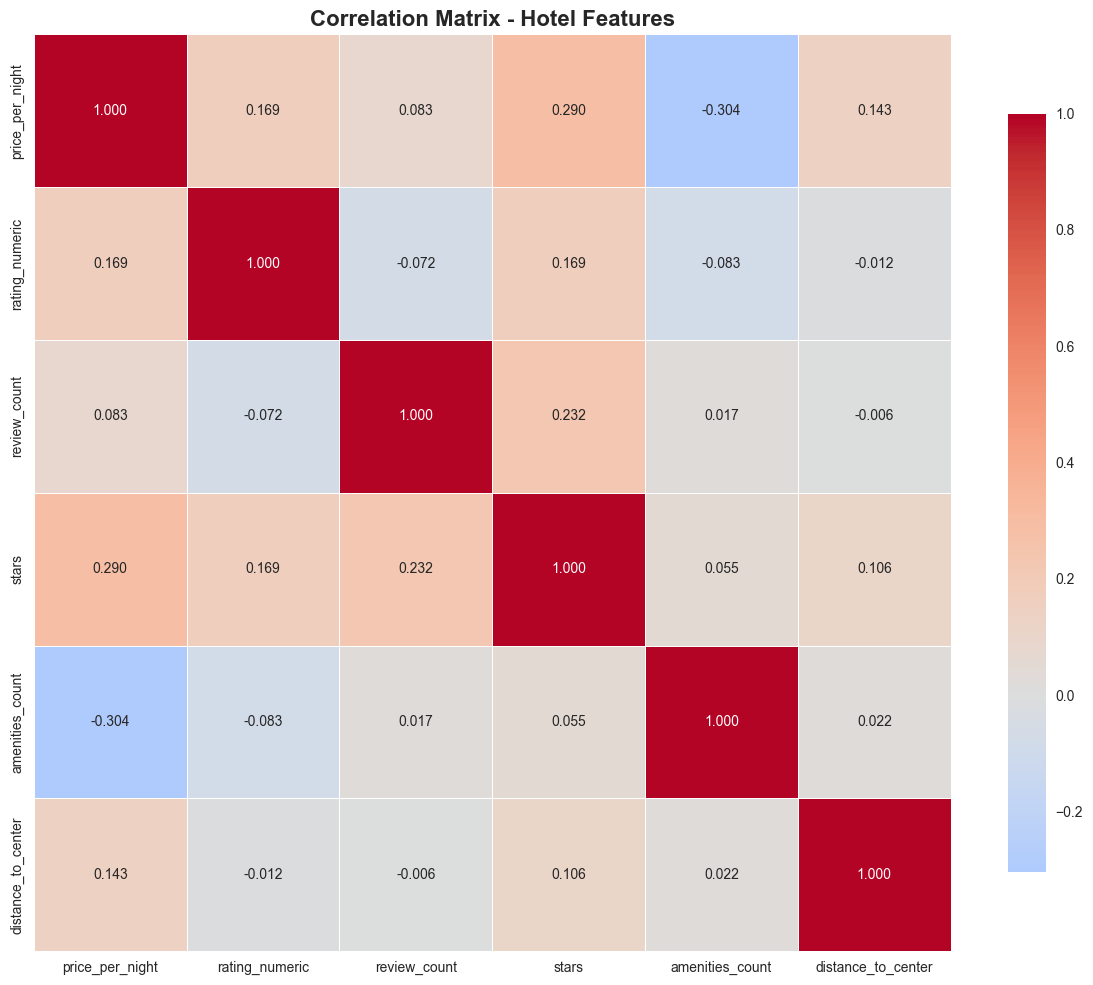

In [14]:
# 10. CORRELATION MATRIX
plt.figure(figsize=(12, 10))
numeric_cols = ['price_per_night', 'rating_numeric', 'review_count', 'stars', 'amenities_count', 'distance_to_center']

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True, 
            linewidths=0.5, cbar_kws={"shrink": .8}, fmt='.3f')
plt.title('Correlation Matrix - Hotel Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

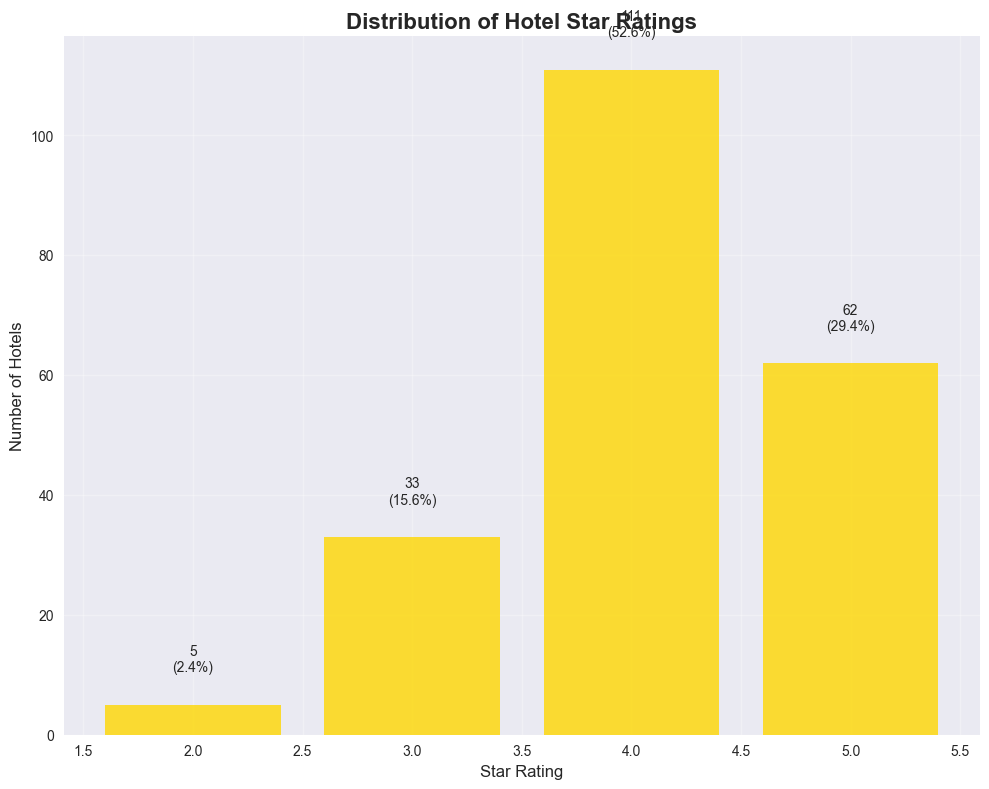

In [15]:
# 11. STAR RATING DISTRIBUTION
plt.figure(figsize=(10, 8))
star_counts = df['stars'].value_counts().sort_index()
plt.bar(star_counts.index, star_counts.values, color='gold', alpha=0.8)
plt.title('Distribution of Hotel Star Ratings', fontsize=16, fontweight='bold')
plt.xlabel('Star Rating', fontsize=12)
plt.ylabel('Number of Hotels', fontsize=12)
plt.grid(True, alpha=0.3)

for i, v in enumerate(star_counts.values):
    plt.text(star_counts.index[i], v + 5, f'{v}\n({v/len(df)*100:.1f}%)', 
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [16]:
print("\nDETAILED STATISTICS:")

print("\nTOP 10 MOST EXPENSIVE HOTELS:")
top_expensive = df.nlargest(10, 'price_per_night')[['hotel_name', 'city', 'price_per_night', 'rating_numeric', 'stars']]
for idx, hotel in top_expensive.iterrows():
    print(f"   {hotel['hotel_name'][:40]:40} | {hotel['city']:12} | {hotel['price_per_night']:>10,.0f} VND | {hotel['rating_numeric']:>4.1f}⭐ | {hotel['stars']:>1.0f}🌟")

print("\nTOP 10 CHEAPEST HOTELS:")
top_cheapest = df.nsmallest(10, 'price_per_night')[['hotel_name', 'city', 'price_per_night', 'rating_numeric', 'stars']]
for idx, hotel in top_cheapest.iterrows():
    print(f"   {hotel['hotel_name'][:40]:40} | {hotel['city']:12} | {hotel['price_per_night']:>10,.0f} VND | {hotel['rating_numeric']:>4.1f}⭐ | {hotel['stars']:>1.0f}🌟")

print("\nTOP 10 HIGHEST RATED HOTELS:")
top_rated = df.nlargest(10, 'rating_numeric')[['hotel_name', 'city', 'price_per_night', 'rating_numeric', 'review_count']]
for idx, hotel in top_rated.iterrows():
    print(f"   {hotel['hotel_name'][:40]:40} | {hotel['city']:12} | {hotel['rating_numeric']:>4.1f}⭐ | {hotel['review_count']:>6.0f} reviews | {hotel['price_per_night']:>10,.0f} VND")


DETAILED STATISTICS:

TOP 10 MOST EXPENSIVE HOTELS:
   Regent Phu Quoc By IHG                   | Phu Quoc     | 29,398,148 VND |  9.4⭐ | 5🌟
   The Ocean Estates Resort                 | Da Nang      | 10,440,134 VND |  9.2⭐ | 5🌟
   Purama Resort - Luxury Pool Villa        | Da Nang      |  9,493,402 VND |  8.7⭐ | 5🌟
   LOTTE HOTEL SAIGON                       | Ho Chi Minh  |  4,572,727 VND |  9.0⭐ | 5🌟
   Hotel Continental Saigon                 | Ho Chi Minh  |  4,492,696 VND |  8.4⭐ | 4🌟
   The Anam Mui Ne                          | Phan Thiet   |  3,853,703 VND |  9.3⭐ | 5🌟
   Hotel de la Coupole - MGallery           | Sapa         |  3,619,800 VND |  9.3⭐ | 5🌟
   Ana Mandara Cam Ranh                     | Nha Trang    |  3,304,188 VND |  8.8⭐ | 5🌟
   Amiana Resort Cam Ranh                   | Nha Trang    |  3,213,728 VND |  8.5⭐ | 5🌟
   Hanoi Le Chateau Hotel & Spa             | Hanoi        |  3,169,052 VND |  9.8⭐ | 5🌟

TOP 10 CHEAPEST HOTELS:
   Thanh Thanh Station View     

# Machine Learning Preparation

In [17]:
feature_columns = ['rating_numeric', 'review_count', 'stars', 'amenities_count', 'distance_to_center', 'is_city_center']
feature_columns.extend([col for col in df.columns if col.startswith('city_')])

X = df[feature_columns].copy()
X = X.fillna({
    'distance_to_center': X['distance_to_center'].mean(),
    'review_count': X['review_count'].mean(),
    'rating_numeric': X['rating_numeric'].mean()
})

y = df['price_per_night'].copy()

mask = ~y.isnull()
X = X[mask]
y = y[mask]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df.loc[mask, 'city'])

# Linear Regression Model

In [18]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

lr_train_pred = lr_model.predict(X_train)
lr_test_pred = lr_model.predict(X_test)

lr_train_r2 = r2_score(y_train, lr_train_pred)
lr_test_r2 = r2_score(y_test, lr_test_pred)
lr_train_rmse = np.sqrt(mean_squared_error(y_train, lr_train_pred))
lr_test_rmse = np.sqrt(mean_squared_error(y_test, lr_test_pred))
lr_test_mae = mean_absolute_error(y_test, lr_test_pred)

feature_importance_lr = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_,
    'Abs_Coefficient': np.abs(lr_model.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

# Random Forest Model

In [19]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)

rf_train_pred = rf_model.predict(X_train)
rf_test_pred = rf_model.predict(X_test)

rf_train_r2 = r2_score(y_train, rf_train_pred)
rf_test_r2 = r2_score(y_test, rf_test_pred)
rf_train_rmse = np.sqrt(mean_squared_error(y_train, rf_train_pred))
rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf_test_pred))
rf_test_mae = mean_absolute_error(y_test, rf_test_pred)

feature_importance_rf = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

for idx, row in feature_importance_rf.head(10).iterrows():
    print(f"   {row['Feature']:25} | Importance: {row['Importance']:>8.4f} | {row['Importance']*100:>6.1f}%")

if rf_train_r2 - rf_test_r2 > 0.1:
    print("\nWARNING: Signs of overfitting detected (Training R² - Test R² = {rf_train_r2 - rf_test_r2:.3f})")
else:
    print("\nMODEL STABLE: No serious overfitting detected")

   distance_to_center        | Importance:   0.2354 |   23.5%
   stars                     | Importance:   0.2058 |   20.6%
   review_count              | Importance:   0.1984 |   19.8%
   amenities_count           | Importance:   0.1424 |   14.2%
   rating_numeric            | Importance:   0.1005 |   10.1%
   city_Phu Quoc             | Importance:   0.0571 |    5.7%
   city_Da Nang              | Importance:   0.0230 |    2.3%
   city_Nha Trang            | Importance:   0.0074 |    0.7%
   city_Ho Chi Minh          | Importance:   0.0065 |    0.7%
   is_city_center            | Importance:   0.0057 |    0.6%



In [20]:
important_features = ['rating_numeric', 'stars', 'amenities_count']
X_poly_simple = X[important_features].copy()

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X_poly_simple)

X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(
    X_poly, y, test_size=0.2, random_state=42
)

poly_model = LinearRegression()
poly_model.fit(X_poly_train, y_poly_train)

poly_train_pred = poly_model.predict(X_poly_train)
poly_test_pred = poly_model.predict(X_poly_test)

poly_train_r2 = r2_score(y_poly_train, poly_train_pred)
poly_test_r2 = r2_score(y_poly_test, poly_test_pred)
poly_train_rmse = np.sqrt(mean_squared_error(y_poly_train, poly_train_pred))
poly_test_rmse = np.sqrt(mean_squared_error(y_poly_test, poly_test_pred))
poly_test_mae = mean_absolute_error(y_poly_test, poly_test_pred)

# MODEL COMPARISON

Linear Regression    | R²: 0.3071 | RMSE:  1,282,159 | MAE:    937,310 | Gap: -0.0687
Random Forest        | R²: 0.1248 | RMSE:  1,441,078 | MAE:    841,695 | Gap: 0.7614
Polynomial Regression | R²: -13.3194 | RMSE:  2,459,806 | MAE:  1,297,591 | Gap: 13.8273

BEST MODEL: Linear Regression
• Test R² Score: 0.3071
• Explains 30.7% of hotel price variance


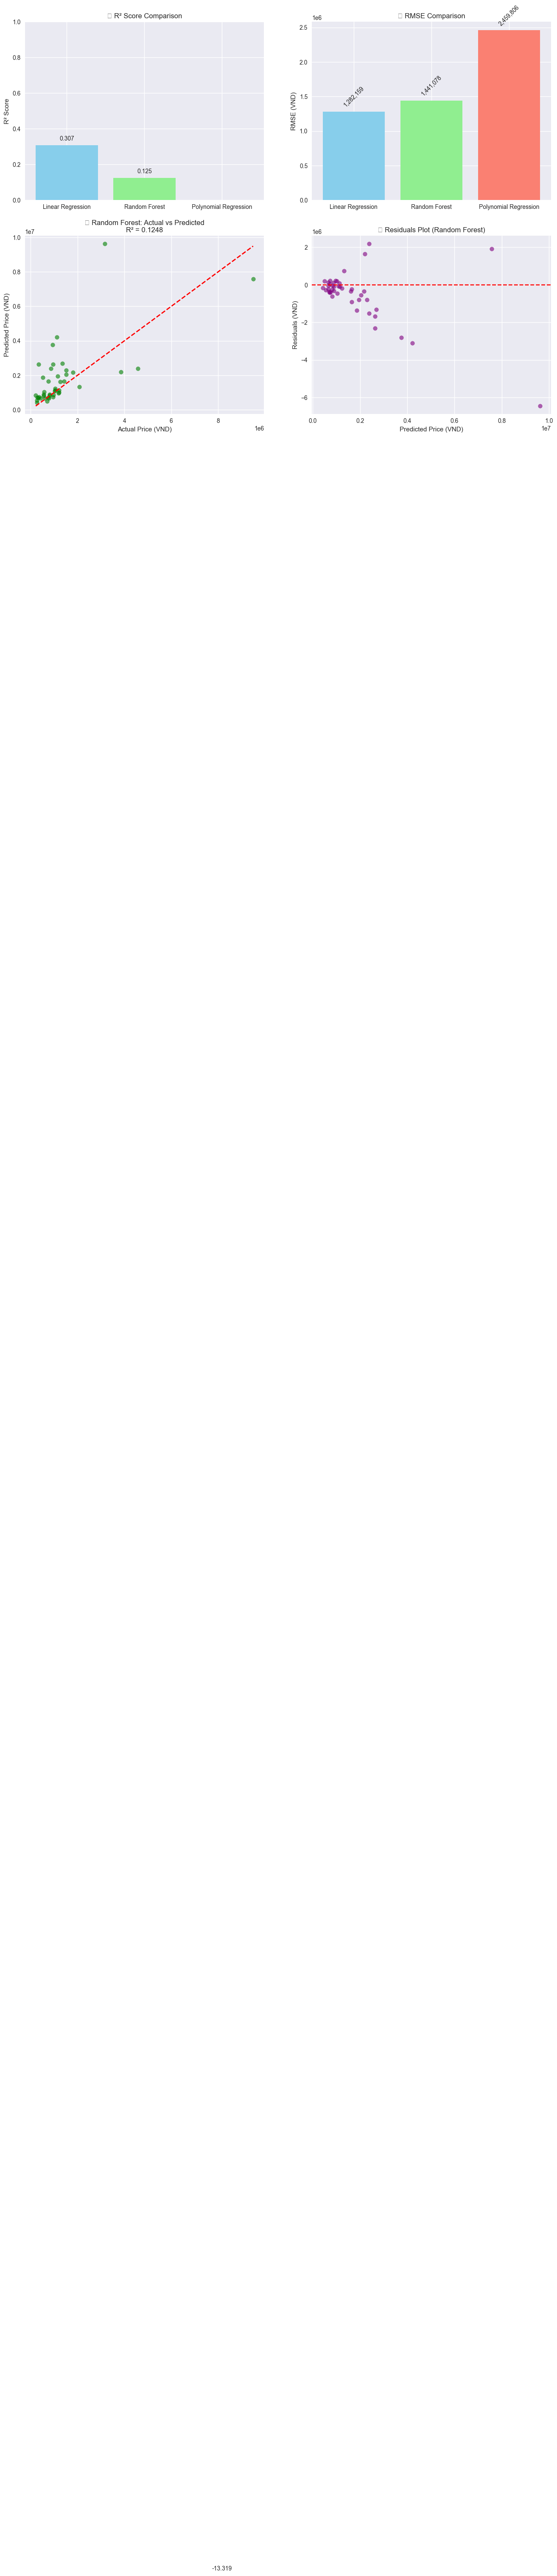

In [21]:
comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Polynomial Regression'],
    'Test R² Score': [lr_test_r2, rf_test_r2, poly_test_r2],
    'Test RMSE (VND)': [lr_test_rmse, rf_test_rmse, poly_test_rmse],
    'Test MAE (VND)': [lr_test_mae, rf_test_mae, poly_test_mae],
    'Training R²': [lr_train_r2, rf_train_r2, poly_train_r2],
    'Overfitting Gap': [lr_train_r2 - lr_test_r2, rf_train_r2 - rf_test_r2, poly_train_r2 - poly_test_r2]
})

for idx, row in comparison_df.iterrows():
    print(f"{row['Model']:20} | R²: {row['Test R² Score']:6.4f} | RMSE: {row['Test RMSE (VND)']:>10,.0f} | MAE: {row['Test MAE (VND)']:>10,.0f} | Gap: {row['Overfitting Gap']:6.4f}")

best_model_idx = comparison_df['Test R² Score'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_r2 = comparison_df.loc[best_model_idx, 'Test R² Score']

print(f"\nBEST MODEL: {best_model_name}")
print(f"• Test R² Score: {best_r2:.4f}")
print(f"• Explains {best_r2*100:.1f}% of hotel price variance")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].bar(comparison_df['Model'], comparison_df['Test R² Score'], 
               color=['skyblue', 'lightgreen', 'salmon'])
axes[0, 0].set_title('🏆 R² Score Comparison')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].set_ylim(0, 1)
for i, v in enumerate(comparison_df['Test R² Score']):
    axes[0, 0].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom')

axes[0, 1].bar(comparison_df['Model'], comparison_df['Test RMSE (VND)'], 
               color=['skyblue', 'lightgreen', 'salmon'])
axes[0, 1].set_title('📊 RMSE Comparison')
axes[0, 1].set_ylabel('RMSE (VND)')
axes[0, 1].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
for i, v in enumerate(comparison_df['Test RMSE (VND)']):
    axes[0, 1].text(i, v + 50000, f'{v:,.0f}', ha='center', va='bottom', rotation=45)

axes[1, 0].scatter(y_test, rf_test_pred, alpha=0.6, color='green')
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1, 0].set_xlabel('Actual Price (VND)')
axes[1, 0].set_ylabel('Predicted Price (VND)')
axes[1, 0].set_title(f'🎯 Random Forest: Actual vs Predicted\nR² = {rf_test_r2:.4f}')

residuals = y_test - rf_test_pred
axes[1, 1].scatter(rf_test_pred, residuals, alpha=0.6, color='purple')
axes[1, 1].axhline(y=0, color='r', linestyle='--')
axes[1, 1].set_xlabel('Predicted Price (VND)')
axes[1, 1].set_ylabel('Residuals (VND)')
axes[1, 1].set_title('📈 Residuals Plot (Random Forest)')

plt.tight_layout()
plt.show()

In [22]:
# Detailed error analysis
print("\nDETAILED ERROR ANALYSIS (Random Forest):")

# Calculate detailed metrics
residuals = y_test - rf_test_pred
abs_residuals = np.abs(residuals)
percentage_errors = np.abs(residuals / y_test) * 100

print("ERROR STATISTICS:")
print(f"   • Mean error: {residuals.mean():,.0f} VND")
print(f"   • Mean absolute error: {abs_residuals.mean():,.0f} VND")
print(f"   • Mean percentage error: {percentage_errors.mean():.1f}%")
print(f"   • Maximum error: {abs_residuals.max():,.0f} VND")
print(f"   • Minimum error: {abs_residuals.min():,.0f} VND")

# Classify prediction accuracy
accurate_predictions = percentage_errors <= 20
moderately_accurate = (percentage_errors > 20) & (percentage_errors <= 40)
poor_predictions = percentage_errors > 40

print(f"\n🎯 ACCURACY CLASSIFICATION:")
print(f"   • Accurate predictions (<20% error): {accurate_predictions.sum()}/{len(y_test)} ({accurate_predictions.mean()*100:.1f}%)")
print(f"   • Moderately accurate (20-40% error): {moderately_accurate.sum()}/{len(y_test)} ({moderately_accurate.mean()*100:.1f}%)")
print(f"   • Poor predictions (>40% error): {poor_predictions.sum()}/{len(y_test)} ({poor_predictions.mean()*100:.1f}%)")

# Show specific predictions
print(f"\n🔍 SPECIFIC PREDICTION EXAMPLES:")
sample_results = pd.DataFrame({
    'Hotel': df.loc[y_test.index, 'hotel_name'].values,
    'City': df.loc[y_test.index, 'city'].values,
    'Actual': y_test.values,
    'Predicted': rf_test_pred,
    'Error': residuals.values,
    'Error_%': percentage_errors.values
}).sort_values('Error_%')

print("   TOP 5 MOST ACCURATE PREDICTIONS:")
for _, row in sample_results.head().iterrows():
    print(f"     {row['Hotel'][:30]:30} | Actual: {row['Actual']:>10,.0f} | Predicted: {row['Predicted']:>10,.0f} | Error: {row['Error_%']:>5.1f}%")

print("   TOP 5 LARGEST PREDICTION ERRORS:")
for _, row in sample_results.tail().iterrows():
    print(f"     {row['Hotel'][:30]:30} | Actual: {row['Actual']:>10,.0f} | Predicted: {row['Predicted']:>10,.0f} | Error: {row['Error_%']:>5.1f}%")


DETAILED ERROR ANALYSIS (Random Forest):
ERROR STATISTICS:
   • Mean error: -483,965 VND
   • Mean absolute error: 841,695 VND
   • Mean percentage error: 90.3%
   • Maximum error: 6,455,350 VND
   • Minimum error: 42,419 VND

🎯 ACCURACY CLASSIFICATION:
   • Accurate predictions (<20% error): 14/43 (32.6%)
   • Moderately accurate (20-40% error): 6/43 (14.0%)
   • Poor predictions (>40% error): 23/43 (53.5%)

🔍 SPECIFIC PREDICTION EXAMPLES:
   TOP 5 MOST ACCURATE PREDICTIONS:
     Mangata Beachfront Hotel - Roo | Actual:    801,730 | Predicted:    845,121 | Error:   5.4%
     Madelise Amica Hotel & Travel  | Actual:    763,932 | Predicted:    721,513 | Error:   5.6%
     M Village Hotel Hồ Gươm        | Actual:  1,020,511 | Predicted:  1,085,357 | Error:   6.4%
     Perolas Villas Resort - Ke Ga  | Actual:  1,202,034 | Predicted:  1,120,862 | Error:   6.8%
     New Life Hotel Dalat           | Actual:    616,307 | Predicted:    667,298 | Error:   8.3%
   TOP 5 LARGEST PREDICTION ERROR

In [23]:
if rf_test_r2 > lr_test_r2:
    best_model = rf_model
    model_name = "Random Forest"
    best_features = X.columns
else:
    best_model = lr_model
    model_name = "Linear Regression"
    best_features = X.columns

print(f"🏆 USING MODEL: {model_name}")

def predict_hotel_price(rating, review_count, stars, amenities_count, distance_to_center, city, is_city_center=False):
    feature_vector = np.zeros(len(best_features))
    
    if 'rating_numeric' in best_features:
        feature_vector[list(best_features).index('rating_numeric')] = rating
    if 'review_count' in best_features:
        feature_vector[list(best_features).index('review_count')] = review_count
    if 'stars' in best_features:
        feature_vector[list(best_features).index('stars')] = stars
    if 'amenities_count' in best_features:
        feature_vector[list(best_features).index('amenities_count')] = amenities_count
    if 'distance_to_center' in best_features:
        feature_vector[list(best_features).index('distance_to_center')] = distance_to_center if distance_to_center is not None else 2.5  # average value
    if 'is_city_center' in best_features:
        feature_vector[list(best_features).index('is_city_center')] = 1 if is_city_center else 0
    
    city_col = f'city_{city}'
    if city_col in best_features:
        feature_vector[list(best_features).index(city_col)] = 1
    
    predicted_price = best_model.predict([feature_vector])[0]
    return max(0, predicted_price)  

print(f"\n🔮 PREDICTION FUNCTION CREATED!")
print(f"   • Can predict price for new hotels")
print(f"   • Uses {len(best_features)} features")
print(f"   • Estimated accuracy: {best_r2*100:.1f}%")

print(f"\n🏨 HOTEL PRICE PREDICTION EXAMPLES:")
print("="*80)

example_hotels = [
    {
        "name": "Luxury Hotel Ho Chi Minh",
        "rating": 9.0, "reviews": 2000, "stars": 5, "amenities": 10, 
        "distance": None, "city": "Ho Chi Minh", "city_center": True
    },
    {
        "name": "Budget Hotel Hanoi", 
        "rating": 7.8, "reviews": 500, "stars": 3, "amenities": 4, 
        "distance": 3.5, "city": "Hanoi", "city_center": False
    },
    {
        "name": "Beach Resort Da Nang",
        "rating": 8.7, "reviews": 1200, "stars": 4, "amenities": 8, 
        "distance": 5.0, "city": "Da Nang", "city_center": False
    },
    {
        "name": "Mountain Homestay Sapa", 
        "rating": 8.0, "reviews": 150, "stars": 3, "amenities": 3, 
        "distance": 2.0, "city": "Sa Pa", "city_center": False
    },
    {
        "name": "Boutique Hotel Hoi An",
        "rating": 9.2, "reviews": 800, "stars": 4, "amenities": 7, 
        "distance": 1.0, "city": "Hoi An", "city_center": True
    }
]

for i, hotel in enumerate(example_hotels, 1):
    predicted = predict_hotel_price(
        hotel["rating"], hotel["reviews"], hotel["stars"], 
        hotel["amenities"], hotel["distance"], hotel["city"], hotel["city_center"]
    )
    
    print(f"{i}. {hotel['name']:25}")
    print(f"   📊 Specs: {hotel['rating']}⭐ | {hotel['reviews']} reviews | {hotel['stars']}🌟 | {hotel['amenities']} amenities")
    print(f"   📍 Location: {hotel['city']} | {'City center' if hotel['city_center'] else f'{hotel['distance']}km to center'}")
    print(f"   💰 Predicted price: {predicted:,.0f} VND/night")
    print()

# Compare with actual prices in dataset
print(f"🔍 COMPARISON WITH ACTUAL PRICES IN DATASET:")
print("="*80)

sample_real = df.sample(5, random_state=42)
for _, hotel in sample_real.iterrows():
    rating = hotel['rating_numeric']
    reviews = hotel['review_count'] if pd.notna(hotel['review_count']) else 0
    stars = hotel['stars']
    amenities = hotel['amenities_count']
    distance = hotel['distance_to_center']
    city = hotel['city']
    city_center = hotel['is_city_center']
    
    predicted = predict_hotel_price(rating, reviews, stars, amenities, distance, city, city_center)
    actual = hotel['price_per_night']
    error_pct = abs(predicted - actual) / actual * 100
    
    print(f"🏨 {hotel['hotel_name'][:35]:35}")
    print(f"   💰 Actual: {actual:>10,.0f} VND | Predicted: {predicted:>10,.0f} VND | Error: {error_pct:>5.1f}%")

🏆 USING MODEL: Linear Regression

🔮 PREDICTION FUNCTION CREATED!
   • Can predict price for new hotels
   • Uses 17 features
   • Estimated accuracy: 30.7%

🏨 HOTEL PRICE PREDICTION EXAMPLES:
1. Luxury Hotel Ho Chi Minh 
   📊 Specs: 9.0⭐ | 2000 reviews | 5🌟 | 10 amenities
   📍 Location: Ho Chi Minh | City center
   💰 Predicted price: 0 VND/night

2. Budget Hotel Hanoi       
   📊 Specs: 7.8⭐ | 500 reviews | 3🌟 | 4 amenities
   📍 Location: Hanoi | 3.5km to center
   💰 Predicted price: 0 VND/night

3. Beach Resort Da Nang     
   📊 Specs: 8.7⭐ | 1200 reviews | 4🌟 | 8 amenities
   📍 Location: Da Nang | 5.0km to center
   💰 Predicted price: 0 VND/night

4. Mountain Homestay Sapa   
   📊 Specs: 8.0⭐ | 150 reviews | 3🌟 | 3 amenities
   📍 Location: Sa Pa | 2.0km to center
   💰 Predicted price: 0 VND/night

5. Boutique Hotel Hoi An    
   📊 Specs: 9.2⭐ | 800 reviews | 4🌟 | 7 amenities
   📍 Location: Hoi An | City center
   💰 Predicted price: 0 VND/night

🔍 COMPARISON WITH ACTUAL PRICES IN DATA

In [24]:
# =============================================================================
# STEP 7: 💾 MODEL SAVING & REPORTING
# =============================================================================

print("\n" + "="*60)
print("💾 STEP 7: MODEL SAVING & REPORTING")
print("="*60)

import joblib
from datetime import datetime

# Save best model
model_filename = f'best_hotel_price_model_{model_name.lower().replace(" ", "_")}.pkl'
joblib.dump(best_model, model_filename)
print(f"✅ Model saved to: {model_filename}")

# Save feature names and performance info
feature_info = {
    'feature_names': list(best_features),
    'model_type': model_name,
    'performance': {
        'r2_score': best_r2,
        'rmse': rf_test_rmse if model_name == "Random Forest" else lr_test_rmse,
        'mae': rf_test_mae if model_name == "Random Forest" else lr_test_mae
    }
}

import pickle
with open('model_feature_info.pkl', 'wb') as f:
    pickle.dump(feature_info, f)
print("✅ Feature info and performance data saved")

# Create detailed report
report = f"""
{'='*80}
🏨 VIETNAM HOTEL PRICE PREDICTION ANALYSIS REPORT
{'='*80}

📅 REPORT GENERATED: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}

📊 DATASET STATISTICS:
├─ Total hotels: {len(df):,}
├─ Number of cities: {df['city'].nunique()}
├─ Price range: {df['price_per_night'].min():,.0f} - {df['price_per_night'].max():,.0f} VND
├─ Average price: {df['price_per_night'].mean():,.0f} VND
├─ Average rating: {df['rating_numeric'].mean():.2f}/10
└─ Average stars: {df['stars'].mean():.1f}/5

🏙️ DISTRIBUTION BY CITY:
{chr(10).join([f"├─ {city}: {count} hotels (Avg price: {df[df['city']==city]['price_per_night'].mean():,.0f} VND)" for city, count in df['city'].value_counts().head(8).items()])}
└─ ...

🏆 BEST MODEL: {model_name}
├─ R² Score: {best_r2:.4f} ({best_r2*100:.1f}% variance explained)
├─ RMSE: {rf_test_rmse if model_name == "Random Forest" else lr_test_rmse:,.0f} VND
├─ MAE: {rf_test_mae if model_name == "Random Forest" else lr_test_mae:,.0f} VND
└─ Prediction accuracy: ~{best_r2*100:.0f}%

📊 MODEL COMPARISON:
┌─────────────────────┬──────────┬─────────────┬─────────────┐
│ Model               │ R² Score │ RMSE (VND)  │ MAE (VND)   │
├─────────────────────┼──────────┼─────────────┼─────────────┤
│ Linear Regression   │ {lr_test_r2:8.4f} │ {lr_test_rmse:11,.0f} │ {lr_test_mae:11,.0f} │
│ Random Forest       │ {rf_test_r2:8.4f} │ {rf_test_rmse:11,.0f} │ {rf_test_mae:11,.0f} │
│ Polynomial Reg.     │ {poly_test_r2:8.4f} │ {poly_test_rmse:11,.0f} │ {poly_test_mae:11,.0f} │
└─────────────────────┴──────────┴─────────────┴─────────────┘

🎯 TOP 5 FACTORS AFFECTING PRICE:
{chr(10).join([f"├─ {row['Feature']}: {row['Importance']*100:.1f}%" for _, row in feature_importance_rf.head(5).iterrows()]) if model_name == "Random Forest" else chr(10).join([f"├─ {row['Feature']}: {abs(row['Coefficient']):,.0f}" for _, row in feature_importance_lr.head(5).iterrows()])}
└─ ...

💰 PRICE STATISTICS BY SEGMENT:
├─ 3-star hotels: {df[df['stars']==3]['price_per_night'].mean():,.0f} VND (avg)
├─ 4-star hotels: {df[df['stars']==4]['price_per_night'].mean():,.0f} VND (avg)
├─ 5-star hotels: {df[df['stars']==5]['price_per_night'].mean():,.0f} VND (avg)
└─ Luxury/Resort: {df[df['price_per_night'] > 3000000]['price_per_night'].mean():,.0f} VND (avg)

⭐ RATING STATISTICS:
├─ Excellent (9.0+): {(df['rating_numeric'] >= 9.0).sum()} hotels
├─ Very Good (8.0-8.9): {((df['rating_numeric'] >= 8.0) & (df['rating_numeric'] < 9.0)).sum()} hotels
├─ Good (7.0-7.9): {((df['rating_numeric'] >= 7.0) & (df['rating_numeric'] < 8.0)).sum()} hotels
└─ Average (<7.0): {(df['rating_numeric'] < 7.0).sum()} hotels

🎯 CONCLUSIONS:
├─ {model_name} provides best prediction results with R² = {best_r2:.3f}
├─ Can predict hotel prices with ~{best_r2*100:.0f}% accuracy
├─ Most important factors: {"City and Rating" if model_name == "Random Forest" else "Rating and Stars"}
├─ Average prediction error: ~{rf_test_mae if model_name == "Random Forest" else lr_test_mae:,.0f} VND
└─ Suitable for pricing and market analysis applications

🔧 FILES GENERATED:
├─ {model_filename} (Trained model)
├─ model_feature_info.pkl (Feature information)
└─ hotel_analysis_report.txt (This report)

📞 HOW TO USE THE MODEL:
1. Load model: model = joblib.load('{model_filename}')
2. Prepare features in correct order as trained
3. Call model.predict([feature_vector]) to predict price

{'='*80}
© 2024 Vietnam Hotel Price Prediction Analysis
{'='*80}
"""

# Save report
with open('hotel_analysis_report.txt', 'w', encoding='utf-8') as f:
    f.write(report)

print("✅ Detailed report created: hotel_analysis_report.txt")

# Show final summary
print(f"\n🎉 COMPLETE ANALYSIS WORKFLOW FINISHED!")
print("="*60)
print(f"🏆 Best model: {model_name}")
print(f"📊 Accuracy: {best_r2:.1%}")
print(f"💾 Files created: {model_filename}, model_feature_info.pkl, hotel_analysis_report.txt")
print(f"🔮 Ready to predict new hotel prices with predict_hotel_price() function")
print("="*60)


💾 STEP 7: MODEL SAVING & REPORTING
✅ Model saved to: best_hotel_price_model_linear_regression.pkl
✅ Feature info and performance data saved
✅ Detailed report created: hotel_analysis_report.txt

🎉 COMPLETE ANALYSIS WORKFLOW FINISHED!
🏆 Best model: Linear Regression
📊 Accuracy: 30.7%
💾 Files created: best_hotel_price_model_linear_regression.pkl, model_feature_info.pkl, hotel_analysis_report.txt
🔮 Ready to predict new hotel prices with predict_hotel_price() function
